In [1]:
import os
import numpy as np
import pandas as pd

from prophet import Prophet

In [2]:
df = pd.read_csv('./data/outlier_sample.csv')
df.head()

,Unnamed: 0,ds,y,avg_prc
0,0,2020-07-01,0.0,99900.0
1,1,2020-07-02,0.0,99900.0
2,2,2020-07-03,0.0,99900.0
3,3,2020-07-04,0.0,99900.0
4,4,2020-07-05,0.0,99900.0


In [4]:
df['avg_prc'] = df['avg_prc'] / df['avg_prc'].max() * 100
df['cap'] = 100
df['floor'] = 0

In [5]:
# holiday 처리

day11 = {
    'holiday' : '11day',
    'ds' : ['20{}-{}-11'.format(i, j) for i in range(19, 25) for j in range(1, 13)],
    'lower_window' : 0,
    'upper_window' : 0
}
new_years_day = {
    'holiday' : 'new_years_day',
    'ds' : ['2020-01-25', '2021-02-12'],
    'lower_window' : -2,
    'upper_window' : 2
}
chuseok = {
    'holiday' : 'chuseok',
    'ds' : ['2020-10-01', '2021-09-12'],
    'lower_window' : -2,
    'upper_window' : 2
}

q3 = df['y'].quantile(q=0.75)
iqr = q3 - df['y'].quantile(q=0.25)
thrshd = q3 + (1.5 * iqr)
tmp = df[df.y > thrshd]
outlier_ds = tmp['ds'].astype(str).to_list()

outlier = {
    'holiday' : 'outlier',
    'ds' : outlier_ds,
    'lower_window' : 0,
    'upper_window' : 0
}

holiday = [pd.DataFrame(h) for h in [day11, new_years_day, chuseok, outlier]]
holidays = pd.concat(holiday)

In [7]:
train = df[:-7]
test = df[-7:]

In [8]:
model = Prophet(
    growth = 'logistic',
    holidays=holidays
)
model.add_country_holidays(country_name='KR')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_regressor('avg_prc', standardize=False)
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.07568


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1219.92     0.0340433       19440.2           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1229.21    0.00286871         37652      0.3793     0.03793      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1271.12     0.0220367       1248.98      0.4222           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1283.25    0.00482625       14449.1      0.3542           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1287.83   9.11875e-05       489.112   0.0006406           1      790   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [9]:
future = model.make_future_dataframe(periods=7)
future['avg_prc'] = df['avg_prc']
future['cap'] = 100
future['floor'] = 0

forecast = model.predict(future)

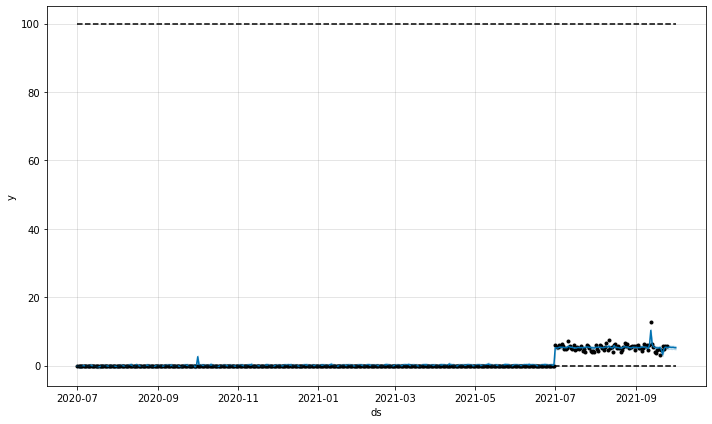

In [10]:
fig = model.plot(forecast)